# Problématique

SNCF-Transilien, l'opérateur des trains de banlieue d'Île-de-France, cherche à mieux anticiper l'augmentation du nombre de validations de cartes à puce par jour et par gare. Cette anticipation est cruciale pour améliorer la performance opérationnelle et proposer des services plus adaptés. Entre 2015 et 2019, le nombre de validations a augmenté d'environ 6% par an. Le but de ce challenge est de prédire le nombre de validations par jour et par gare à moyen et long terme.

## Objectif


L'objectif principal est de développer un modèle de machine learning capable de prédire le nombre de validations quotidiennes pour chaque gare du réseau SNCF-Transilien sur la période du 1er janvier 2023 au 30 juin 2023.

In [1]:
import pandas as pd

# Importer les fichiers
train_data = pd.read_csv('data/train_f_x.csv')
test_data = pd.read_csv('data/test_f_x_THurtzP.csv')
y_train = pd.read_csv('data/y_train_sncf.csv')
y_example = pd.read_csv('data/y_exemple_sncf_d9so9pm.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/test_f_x_THurtzP.csv'

## Préparation des Données

In [2]:
from sklearn.model_selection import train_test_split

# Conversion de la colonne 'date' en type datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Extraire les informations de 'index' dans y_train
y_train['date'] = y_train['index'].str.split('_').str[0]
y_train['station'] = y_train['index'].str.split('_').str[1]

# Conversion de la colonne 'date' en type datetime pour y_train
y_train['date'] = pd.to_datetime(y_train['date'])

# Fusionner les données d'entraînement avec les valeurs cibles
train_full = train_data.merge(y_train, on=['date', 'station'])

# Séparer les features et la cible
X = train_full.drop(columns=['y', 'index'])
y = train_full['y']

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Afficher les formes des ensembles
print(f'Taille de X_train: {X_train.shape}')
print(f'Taille de X_val: {X_val.shape}')
print(f'Taille de y_train: {y_train.shape}')
print(f'Taille de y_val: {y_val.shape}')

Taille de X_train: (983890, 5)
Taille de X_val: (245973, 5)
Taille de y_train: (983890,)
Taille de y_val: (245973,)


# Construction des Features

## A partir des dates

In [3]:
# Extraire des informations de la date
for df in [X_train, X_val, test_data]:
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week

# Supprimer la colonne 'date' après l'extraction des features
X_train = X_train.drop(columns=['date'])
X_val = X_val.drop(columns=['date'])
test_data = test_data.drop(columns=['date'])


## Variables categorielles

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Séparation des features numériques et catégorielles
numerical_features = ['job', 'ferie', 'vacances', 'day', 'month', 'year', 'day_of_week', 'week_of_year']
categorical_features = ['station']

# Construction du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


## Analyse des données

                 job          ferie       vacances            day  \
count  983890.000000  983890.000000  983890.000000  983890.000000   
mean        0.717204       0.029979       0.339734      15.706595   
std         0.450358       0.170529       0.473619       8.798830   
min         0.000000       0.000000       0.000000       1.000000   
25%         0.000000       0.000000       0.000000       8.000000   
50%         1.000000       0.000000       0.000000      16.000000   
75%         1.000000       0.000000       1.000000      23.000000   
max         1.000000       1.000000       1.000000      31.000000   

               month           year    day_of_week  week_of_year  
count  983890.000000  983890.000000  983890.000000      983890.0  
mean        6.525590    2018.494525       2.989471     26.657124  
std         3.453341       2.294228       1.997244      15.08412  
min         1.000000    2015.000000       0.000000           1.0  
25%         4.000000    2016.000000       1

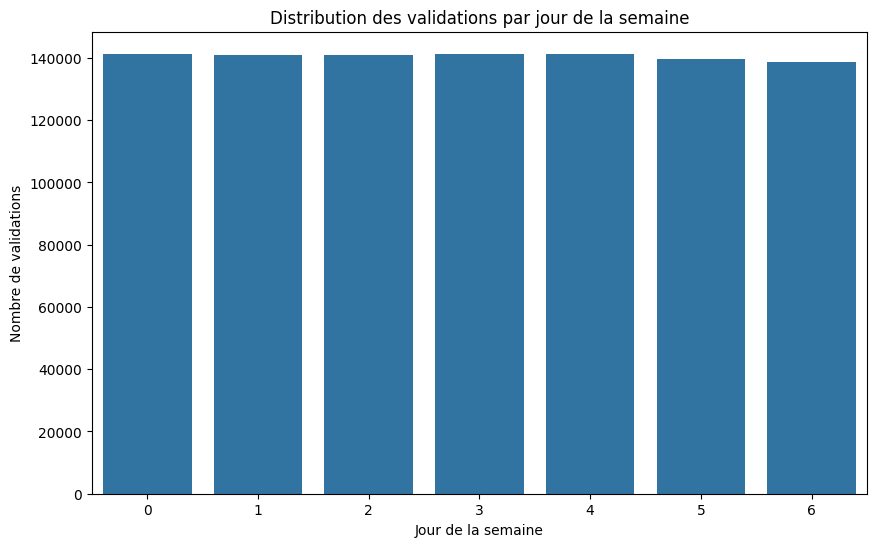

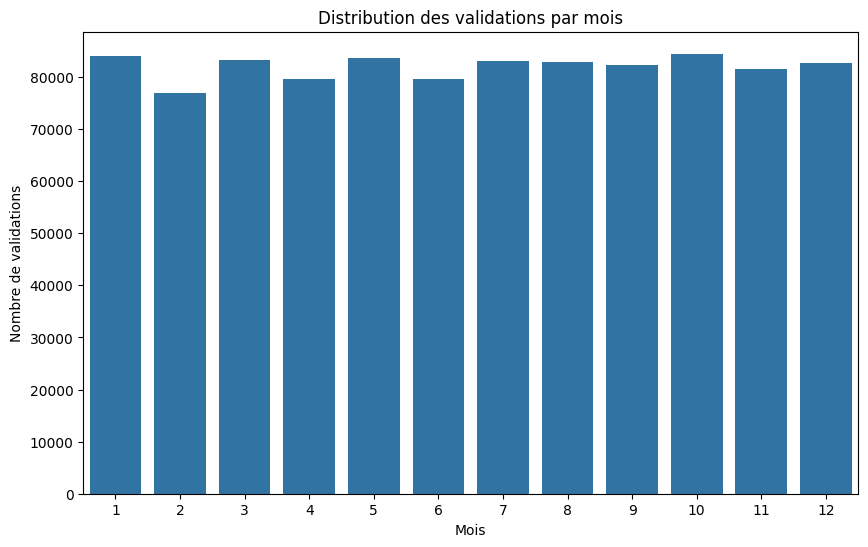

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Statistiques descriptives des features numériques
print(X_train.describe())

# Distribution des validations par jour de la semaine
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=X_train)
plt.title('Distribution des validations par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de validations')
plt.show()

# Distribution des validations par mois
plt.figure(figsize=(10, 6))
sns.countplot(x='month', data=X_train)
plt.title('Distribution des validations par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de validations')
plt.show()


#### Statistiques Descriptives des Features

##### `job` :
- La moyenne est de 0.717, indiquant que la majorité des jours sont des jours ouvrables.
- La valeur maximale est 1 (jours ouvrables) et la minimale est 0 (weekends et jours fériés).

##### `ferie` :
- La moyenne est de 0.029, montrant que les jours fériés sont rares.
- La valeur maximale est 1 (jours fériés) et la minimale est 0 (jours non fériés).

##### `vacances` :
- La moyenne est de 0.34, indiquant qu'environ un tiers des jours sont des jours de vacances scolaires.
- La valeur maximale est 1 (jours de vacances) et la minimale est 0 (jours hors vacances).

##### `day` :
- La moyenne est de 15.71, ce qui correspond à peu près à la moitié du mois.
- La valeur minimale est 1 et la maximale est 31.

##### `month` :
- La moyenne est de 6.53, correspondant à la mi-année.
- La valeur minimale est 1 (Janvier) et la maximale est 12 (Décembre).

##### `year` :
- La moyenne est de 2018.49, indiquant une distribution équilibrée des données sur les années couvertes.
- La valeur minimale est 2015 et la maximale est 2022.

##### `day_of_week` :
- La moyenne est de 2.99, ce qui est proche de Mercredi.
- La valeur minimale est 0 (Lundi) et la maximale est 6 (Dimanche).

##### `week_of_year` :
- La moyenne est de 26.66, ce qui correspond à peu près à la mi-année.
- La valeur minimale est 1 et la maximale est 53.


## Modele

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# Construction du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Pipeline avec préprocesseur et modèle de régression linéaire
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entraînement du modèle
model_lr.fit(X_train, y_train)

# Prédictions
y_pred_lr = model_lr.predict(X_val)

# Calcul du MAPE
mape_lr = mean_absolute_percentage_error(y_val, y_pred_lr)
print(f'MAPE du modèle de régression linéaire: {mape_lr}')


MAPE du modèle de régression linéaire: 4.8578853621746216e+16


Le MAPE du modèle de régression linéaire est extrêmement élevé (4.8578853621746216e+16), ce qui indique que le modèle de régression linéaire de base a des performances médiocres et des prédictions très inexactes. Un MAPE aussi élevé suggère que les prédictions du modèle sont largement incorrectes par rapport aux valeurs réelles.